In [30]:
import torch
import torchvision
import os

import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image

from transformers import BeitForImageClassification, BeitConfig, BeitFeatureExtractor, Trainer, TrainingArguments
from PIL import Image

from tqdm import tqdm
from collections import defaultdict

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as cm

In [31]:
# Check for GPU
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

device

'cuda:0'

In [42]:
class food_train(Dataset):

    def __init__(self, labels_file, img_dir, extractor):
        self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[:25000]
        self.img_dir = img_dir
        self.feature_extractor = extractor
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img = read_image(img_path).numpy().T

        # Apply thresholds for the bound selection
        threshold1,threshold2 = 40, 500
        grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        image = cv2.Canny(img, threshold1, threshold2)

        # Convert images to correct sizes
        image_new = np.repeat(image[:, :, np.newaxis], 3, axis=2)
        grey_new = np.repeat(grey[:, :, np.newaxis], 3, axis=2)

        # Applying grey scale and applying the bounds --> These need to be optimized.
        new_image = img * image_new + (1 - grey_new)
        new_image = img * ((new_image > 40) * (new_image < 230))
        
        label = self.img_labels.iloc[idx, 1]
        new_image = torch.from_numpy(new_image).T
        
        features = self.feature_extractor(images=new_image)["pixel_values"][0]
        label = self.img_labels.iloc[idx, 1]       
            
        return features, label

In [43]:
class food_val(Dataset):

    def __init__(self, labels_file, img_dir, extractor):
        self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[25000:]
        self.img_dir = img_dir
        self.feature_extractor = extractor

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img = read_image(img_path).numpy().T

        # Apply thresholds for the bound selection
        threshold1,threshold2 = 40, 500
        grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        image = cv2.Canny(img, threshold1, threshold2)

        # Convert images to correct sizes
        image_new = np.repeat(image[:, :, np.newaxis], 3, axis=2)
        grey_new = np.repeat(grey[:, :, np.newaxis], 3, axis=2)

        # Applying grey scale and applying the bounds --> These need to be optimized.
        new_image = img * image_new + (1 - grey_new)
        new_image = img * ((new_image > 40) * (new_image < 230))
        
        label = self.img_labels.iloc[idx, 1]
        new_image = torch.from_numpy(new_image).T
        
        features = self.feature_extractor(images=new_image)["pixel_values"][0]
        label = self.img_labels.iloc[idx, 1]       
            
        return features, label

In [44]:
class food_test(Dataset):

    def __init__(self, img_dir, extractor):
        self.img_dir = img_dir
        self.feature_extractor = extractor

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        file_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, file_name)
        img = read_image(img_path).numpy().T

        # Apply thresholds for the bound selection
        threshold1,threshold2 = 40, 500
        grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        image = cv2.Canny(img, threshold1, threshold2)

        # Convert images to correct sizes
        image_new = np.repeat(image[:, :, np.newaxis], 3, axis=2)
        grey_new = np.repeat(grey[:, :, np.newaxis], 3, axis=2)

        # Applying grey scale and applying the bounds --> These need to be optimized.
        new_image = img * image_new + (1 - grey_new)
        new_image = img * ((new_image > 40) * (new_image < 230))
        
        label = self.img_labels.iloc[idx, 1]
        new_image = torch.from_numpy(new_image).T
        
        features = self.feature_extractor(images=new_image)["pixel_values"][0]
        
        features = self.feature_extractor(images=image)["pixel_values"][0]
        
        return file_name, features

In [45]:
img_dir = "../data/train_set/train_set"
labels = "../data/train_labels.csv"

# Resize image to match BEiT, convert to torch.float, normalize
transform = transforms.Compose(
                    [transforms.Resize((224,224)),
                     transforms.ConvertImageDtype(torch.float),
                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])])

feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224")

# Create datasets
train_set = food_train(labels, img_dir, feature_extractor)
trainloader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0)

val_set = food_val(labels, img_dir, feature_extractor)
valloader = DataLoader(val_set, batch_size=16, shuffle=True, num_workers=0)

len(train_set), len(val_set)

(25000, 5611)

In [46]:
test_set = food_test("../data/test_set/test_set", feature_extractor)
testloader = DataLoader(test_set, batch_size = 16)

len(test_set)

7653

In [47]:
# Load BEiT
beit = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224")

In [48]:
# CrossEntropyLoss and SGD optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(beit.parameters(), lr = 0.001, momentum = 0.9)
# optimizer = optim.Adam(beit.parameters(), lr=0.00001)

In [49]:
len(trainloader.dataset)

25000

In [50]:
def train_loop(dataloader, model, criterion, optimizer):
    # Get size of dataset
    size = len(dataloader.dataset)
    # Train on GPU if available
    model = model.to(device)
    model.train()
    
    # Metadata
    stats = defaultdict(list)
    current_acc = 0
    max_acc = 0
    
    stats["epoch"].append(0)
    stats["loss"].append(8.7)
    stats["accuracy"].append(1.25)
    
    for epoch in range(10):
        for batch, (image, label) in enumerate(dataloader):
            # Compute prediction and loss
            image, label = image.to(device), label.to(device)            
            pred = model(image)
            loss = criterion(pred["logits"], label)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print progress
            if batch % 200 == 0:
                loss, current = loss.item(), batch * len(image)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch + 1}")
        
        # Print performance after current number of epochs
        print(f"Epoch: {epoch + 1}")
        current_acc, avg_loss = test_loop(valloader, model, criterion)
        
        if current_acc > max_acc:
            PATH = f'../../beit_optimal.pth'
            torch.save(beit.state_dict(), PATH)
            max_acc = current_acc
            
        # Store metadata
        stats["epoch"].append(epoch + 1)
        stats["accuracy"].append(current_acc)
        stats["loss"].append(avg_loss)
        
        # Plot progress
        fig, ax1 = plt.subplots()

        color = "tab:blue"
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss", color=color)
        ax1.plot(stats["epoch"], stats["loss"], color=color)
        ax1.tick_params(axis="y", labelcolor=color)

        ax2 = ax1.twinx()

        color = "tab:orange"
        ax2.set_ylabel("Accuracy", color=color)
        ax2.plot(stats["epoch"], stats["accuracy"], color=color)
        ax2.tick_params(axis="y", labelcolor=color)
        plt.show()
    
    def train_loop(dataset, model, criterion, optimizer, labels, 
               img_dir, feature_extractor = None, transform = None, train_size = 0.8):
    # Train on GPU if available
    model = model.to(device)
    model.train()
    
    # Metadata
    stats = defaultdict(list)
    current_acc = 0
    max_acc = 0
    
    stats["epoch"].append(0)
    stats["loss"].append(8.7)
    stats["accuracy"].append(1.25)
        
    for epoch in range(40):
        # Calculate size of train sample
        train_sample = int(len(dataset) * train_size)
        
        # Get indeces of train and validation set
        n_train = random.sample(set(np.arange(len(dataset))), train_sample)
        n_val = range(len(dataset))
        n_val = list(set(n_val) - set(n_train))
        
        # Get the samples at those indeces
        trainset = food_set(labels, img_dir, feature_extractor, transform = transform, n = n_train)
        valset = food_set(labels, img_dir, feature_extractor, transform = transform, 
                          n = n_val)
        
        # Create a DataLoader with the data
        trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=0)
        valloader = DataLoader(valset, batch_size=16, shuffle=True, num_workers=0)
        
        size = len(trainloader.dataset)
        
        for batch, (image, label) in enumerate(trainloader):
            # Compute prediction and loss
            image, label = image.to(device), label.to(device)            
            pred = model(image)
            loss = criterion(pred["logits"], label)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print progress
            if batch % 200 == 0:
                loss, current = loss.item(), batch * len(image)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch + 1}")
        
        # Print performance after current number of epochs
        print(f"Epoch: {epoch + 1}")
        current_acc, avg_loss = test_loop(valloader, model, criterion)
        
        if current_acc > max_acc:
            PATH = f'../../beit_weights.pth'
            torch.save(beit.state_dict(), PATH)
            max_acc = current_acc
            
        # Store metadata
        stats["epoch"].append(epoch + 1)
        stats["accuracy"].append(current_acc)
        stats["loss"].append(avg_loss)
        
        # Plot progress
        fig, ax1 = plt.subplots()

        color = "tab:blue"
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss", color=color)
        ax1.plot(stats["epoch"], stats["loss"], color=color)
        ax1.tick_params(axis="y", labelcolor=color)

        ax2 = ax1.twinx()

        color = "tab:orange"
        ax2.set_ylabel("Accuracy", color=color)
        ax2.plot(stats["epoch"], stats["accuracy"], color=color)
        ax2.tick_params(axis="y", labelcolor=color)
        plt.show()
    
    return stats


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += criterion(pred["logits"], label).item()
            correct += (pred["logits"].argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100 * correct), test_lossreturn stats


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += criterion(pred["logits"], label).item()
            correct += (pred["logits"].argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100 * correct), test_loss

loss: 8.791654  [    0/25000] epoch: 1
loss: 4.550992  [ 3200/25000] epoch: 1
loss: 4.185511  [ 6400/25000] epoch: 1
loss: 4.501808  [ 9600/25000] epoch: 1
loss: 4.300653  [12800/25000] epoch: 1
loss: 4.156388  [16000/25000] epoch: 1
loss: 4.291621  [19200/25000] epoch: 1
loss: 4.180246  [22400/25000] epoch: 1
Epoch: 1
Test Error: 
 Accuracy: 9.3%, Avg loss: 4.013906 



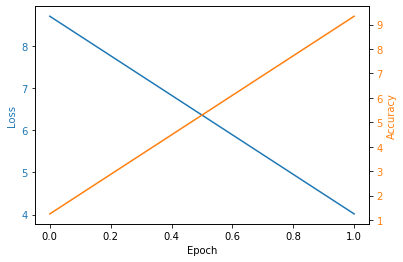

loss: 4.028281  [    0/25000] epoch: 2
loss: 3.343397  [ 3200/25000] epoch: 2
loss: 3.552406  [ 6400/25000] epoch: 2
loss: 3.545006  [ 9600/25000] epoch: 2
loss: 3.538670  [12800/25000] epoch: 2
loss: 2.683423  [16000/25000] epoch: 2
loss: 2.684119  [19200/25000] epoch: 2
loss: 3.241537  [22400/25000] epoch: 2
Epoch: 2
Test Error: 
 Accuracy: 35.8%, Avg loss: 2.569139 



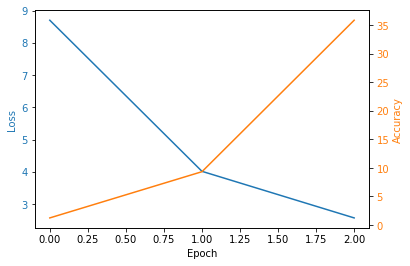

loss: 2.265111  [    0/25000] epoch: 3
loss: 1.446600  [ 3200/25000] epoch: 3
loss: 2.383486  [ 6400/25000] epoch: 3
loss: 2.305371  [ 9600/25000] epoch: 3
loss: 1.853771  [12800/25000] epoch: 3
loss: 1.064929  [16000/25000] epoch: 3
loss: 2.506169  [19200/25000] epoch: 3
loss: 1.916145  [22400/25000] epoch: 3
Epoch: 3
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.713994 



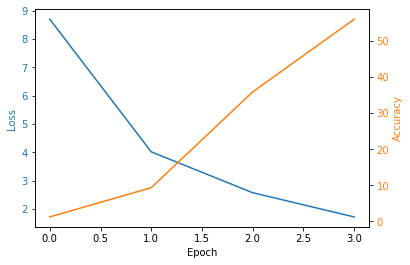

loss: 1.184715  [    0/25000] epoch: 4
loss: 1.553134  [ 3200/25000] epoch: 4
loss: 0.889885  [ 6400/25000] epoch: 4
loss: 2.290163  [ 9600/25000] epoch: 4
loss: 1.003765  [12800/25000] epoch: 4
loss: 0.942046  [16000/25000] epoch: 4
loss: 1.811589  [19200/25000] epoch: 4
loss: 0.776277  [22400/25000] epoch: 4
Epoch: 4
Test Error: 
 Accuracy: 61.9%, Avg loss: 1.511427 



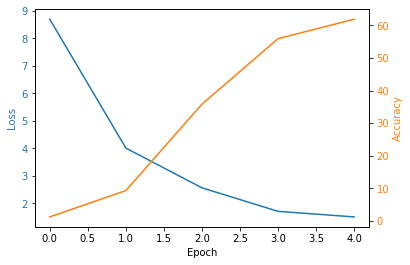

loss: 0.216207  [    0/25000] epoch: 5
loss: 0.966410  [ 3200/25000] epoch: 5
loss: 1.061050  [ 6400/25000] epoch: 5
loss: 0.652501  [ 9600/25000] epoch: 5
loss: 0.743316  [12800/25000] epoch: 5
loss: 0.291192  [16000/25000] epoch: 5
loss: 1.024701  [19200/25000] epoch: 5
loss: 0.507026  [22400/25000] epoch: 5
Epoch: 5
Test Error: 
 Accuracy: 61.6%, Avg loss: 1.512538 



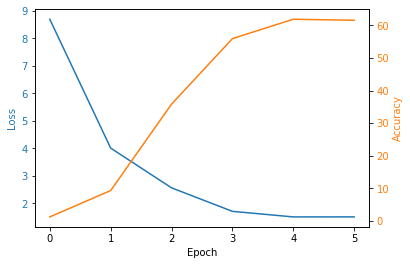

loss: 0.252945  [    0/25000] epoch: 6
loss: 1.039270  [ 3200/25000] epoch: 6


KeyboardInterrupt: 

In [51]:
stats = train_loop(trainloader, beit, criterion, optimizer)

In [33]:
# PATH = './transfered_beit.pth'
# torch.save(beit.state_dict(), PATH)S

In [34]:
test_results = {"img_name" : [], "label": []}

for file_name, image in tqdm(testloader):
    X = image.to(device)
    pred = beit(X)["logits"].argmax(1)
    
    test_results["img_name"] += file_name
    test_results["label"] += [int(i) for i in pred.cpu()]SS

  0%|          | 0/479 [00:00<?, ?it/s]

In [35]:
test_df = pd.DataFrame(test_results)

test_df.head()

,img_name,label
0,test_1.jpg,15
1,test_10.jpg,45
2,test_100.jpg,34
3,test_1000.jpg,29
4,test_1001.jpg,37


In [36]:
test_df.to_csv("submission_beit.csv", index=False)